# Library Imports & Helper Functions

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import community as community_louvain
import community.community_louvain as ml

# Read the full co-occurrence table with counts
df_coocc = pd.read_csv("../data/coocc_gcfs_counts.csv")

In [2]:
def analyze_community_composition(G, attribute_name, plot_title, legend_title, min_size=88, top_n=20):
    """
    Analyzes community composition.
    - Generates a Stacked Bar Chart.
    - Generates a Heatmap (better for reading values).
    """
    print(f"ANALYSIS: Community vs. {attribute_name}")
   

    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])

    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return

    # 1. Clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # 2. Filter Data (Size)
    true_community_sizes = df['community'].value_counts()
    communities_to_keep = true_community_sizes[true_community_sizes >= min_size].index
    df_filtered = df[df['community'].isin(communities_to_keep)].copy()

    # 3. Group Rare Categories into 'Other'
    category_counts = df_filtered[attribute_name].value_counts()
    top_categories = category_counts.nlargest(top_n).index
    
    df_filtered[attribute_name] = df_filtered[attribute_name].apply(
        lambda x: x if x in top_categories else 'other'
    )
    
    print(f"Note: Grouped {len(category_counts) - top_n} rare categories into 'Other'.")

    # create Crosstab
    contingency_table = pd.crosstab(df_filtered['community'], df_filtered[attribute_name])

    
    # Sorts 'Community_1', 'Community_2', ... 'Community_10' correctly
    try:
        sorted_index = sorted(contingency_table.index, key=lambda x: int(str(x).split('_')[1]))
        contingency_table = contingency_table.reindex(sorted_index)
    except Exception as e:
        print(f"Warning: Could not sort numerically ({e}). Fallback to standard sort.")
        contingency_table['TOTAL'] = contingency_table.sum(axis=1)
        contingency_table = contingency_table.sort_values('TOTAL', ascending=False)
        del contingency_table['TOTAL']
    
    
    purity_calc = contingency_table # table is already sorted now
    community_purity = purity_calc.div(purity_calc.sum(axis=1), axis=0).fillna(0) * 100

    # PLOT 1: Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = plt.cm.tab20.colors
    color_map = {}
    color_idx = 0
    for cat in community_purity.columns:
        if cat == 'other':
            color_map[cat] = 'black' 
        else:
            color_map[cat] = colors[color_idx % 20]
            color_idx += 1
    
    community_purity.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, 'gray') for x in community_purity.columns])

    ax.set_title(f'{plot_title} (Top {top_n})', fontsize=16)
    ax.set_xlabel('Community ID', fontsize=12)
    ax.set_ylabel(f'Percentage (%)', fontsize=12)
    ax.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # PLOT 2: Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        community_purity, 
        annot=True,      # Show numbers
        fmt=".0f",       # Round to whole numbers
        cmap="YlGnBu",   # Color scheme
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )
    plt.title(f'{plot_title}', fontsize=16)
    plt.xlabel(legend_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [3]:
#MASTER FUNCTION: Deep Dive Heatmap (No 'Other')
def plot_deep_dive_heatmap(G, attribute_name, plot_title, xlabel_title, min_size=88, threshold_percent=20):
    """
    Generates a detailed heatmap EXCLUDING the 'Other' category.
    Displays EVERY category that has a proportion greater than 
    'threshold_percent' in AT LEAST ONE community.
    """
    print(f"DEEP DIVE HEATMAP: {attribute_name}")

    # find data
    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])
    
    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return
    
    # clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return  ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # create crosstab
    true_community_sizes = df['community'].value_counts()
    contingency_table = pd.crosstab(df['community'], df[attribute_name])

    # 3. Filter & SORT Communities (1, 2, 3...)
    # First, filter out those that are too small
    communities_subset = true_community_sizes[true_community_sizes >= min_size].index
    
    # NOW sort the remaining ones strictly by number (Community_1, Community_2...)
    try:
        sorted_communities = sorted(communities_subset, key=lambda x: int(str(x).split('_')[1]))
    except:
        # Fallback if the name is not "Community_X"
        sorted_communities = communities_subset
        
    # Reorder table
    filtered_contingency = contingency_table.reindex(sorted_communities).fillna(0)

    # calculate puity
    community_purity = filtered_contingency.div(filtered_contingency.sum(axis=1), axis=0) * 100
    
    cols_to_drop = [c for c in community_purity.columns if 'other' in str(c).lower()]
    if cols_to_drop:
        community_purity = community_purity.drop(columns=cols_to_drop)

    # filter
    important_cols = community_purity.columns[(community_purity >= threshold_percent).any()]
    df_heatmap = community_purity[important_cols]
    
    print(f"Showing {len(important_cols)} categories that are >{threshold_percent}% abundant in at least one cluster.")

    if df_heatmap.empty:
        print("No categories met the threshold.")
        return

    # plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        df_heatmap, 
        annot=True, 
        fmt=".0f", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )

    plt.title(f'{plot_title} (Threshold: >{threshold_percent}%)', fontsize=16)
    plt.xlabel(xlabel_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Data Processing & Network Construction

In [4]:
# Compute Jaccard index: a / (a + b + c)
# a = count (co-occurrence)
# b = freq_gcf1 - count (samples with only gcf1)
# c = freq_gcf2 - count (samples with only gcf2)

denominator = df_coocc["freq_gcf1"] + df_coocc["freq_gcf2"] - df_coocc["count"]

# Avoid division by zero
denominator = denominator.replace(0, 1)

df_coocc["jaccard_index"] = df_coocc["count"] / denominator
df_coocc["jaccard_index"] = df_coocc["jaccard_index"].round(8)
# Sort by Jaccard descending
df_coocc = df_coocc.sort_values(by="jaccard_index", ascending=False).reset_index(drop=True)
df_coocc = df_coocc.sort_values(
    by=["jaccard_index", "gcf1", "gcf2"], 
    ascending=[False, True, True]
).reset_index(drop=True)

# Save full table with Jaccard index
df_coocc.to_csv("../data/coocc_gcfs_with_jaccard.csv", index=False)

df_coocc.head(20)


,gcf1,gcf2,count,freq_gcf1,freq_gcf2,jaccard_index
0,GCF_0df2f492b5,GCF_cea89f0dcf,26,26,26,1.0
1,GCF_11d524052c,GCF_29feb4e8ad,37,37,37,1.0
2,GCF_11d524052c,GCF_4b6a48dc37,37,37,37,1.0
3,GCF_11d524052c,GCF_77cb185f51,37,37,37,1.0
4,GCF_11d524052c,GCF_b4b3bbab9b,37,37,37,1.0
5,GCF_1d32c7900e,GCF_c382bc26c0,20,20,20,1.0
6,GCF_27119445a7,GCF_8c1b2c8d09,50,50,50,1.0
7,GCF_29feb4e8ad,GCF_4b6a48dc37,37,37,37,1.0
8,GCF_29feb4e8ad,GCF_77cb185f51,37,37,37,1.0
9,GCF_29feb4e8ad,GCF_b4b3bbab9b,37,37,37,1.0


In [5]:
# Read the full Jaccard results file
jaccard_results = pd.read_csv("../data/coocc_gcfs_with_jaccard.csv")


JACCARD_THRESHOLD = 0.30 

filtered_edges = jaccard_results[jaccard_results["jaccard_index"] > JACCARD_THRESHOLD].copy()

# 'distance' for path-finding metrics
filtered_edges['distance'] = 1.0 - filtered_edges["jaccard_index"]

filtered_edges['strength'] = filtered_edges["jaccard_index"] 

G_jaccard = nx.from_pandas_edgelist(
    filtered_edges,
    source="gcf1",
    target="gcf2",
    edge_attr=['strength', 'distance'] 
)
print(f"Network built. Nodes: {G_jaccard.number_of_nodes()}, Edges: {G_jaccard.number_of_edges()}")

Network built. Nodes: 5201, Edges: 31558


# Structure Analysis & Topology

In [6]:
# betweenness centrality
# calculates node importance as a 'bridge' on shortest paths.
#'weight="weight"', as it seeks paths with the lowest distance (1.0 - Jaccard)
betweenness = nx.betweenness_centrality(G_jaccard, normalized=True, weight="distance")

# add scores to graph node
nx.set_node_attributes(G_jaccard, betweenness, 'betweenness_score')

# Sort and create DataFrame
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
df_scores = pd.DataFrame(sorted_betweenness, columns=['gcf_id', 'betweenness_score'])

# print
print("Top 10 GCFs (Betweenness Centrality)")
print(df_scores.head(10).to_string())

Top 10 GCFs (Betweenness Centrality)
           gcf_id  betweenness_score
0  GCF_1d0c9bca2c           0.054932
1  GCF_71a5e1a76e           0.052549
2  GCF_fed52c71ea           0.042099
3  GCF_d41e2ed479           0.041092
4  GCF_45129e2542           0.039491
5  GCF_ae5058c7b3           0.029584
6  GCF_ceb8e5a21b           0.027240
7  GCF_306abe7dd8           0.027043
8  GCF_ab134eac7a           0.026466
9  GCF_17ea62e730           0.024304


In [7]:
#harmonic centrality
# Calculates how 'central' a node is, but works on disconnected graphs (islands).
# uses 'distance="distance"' to use (1 - Jaccard) edge attribute
harmonic_raw = nx.harmonic_centrality(G_jaccard, distance="distance")

# Normalize the scores
n = G_jaccard.number_of_nodes()
harmonic_normalized = {node: score / (n - 1) for node, score in harmonic_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_jaccard, harmonic_normalized, 'harmonic_score')

# Sort and create DataFrame
df_harmonic = pd.DataFrame(sorted(harmonic_normalized.items(), key=lambda item: item[1], reverse=True),
                           columns=['gcf_id', 'harmonic_score'])

# print
print("Top 10 GCFs (Harmonic Centrality)")
print(df_harmonic.head(10).to_string())

Top 10 GCFs (Harmonic Centrality)
           gcf_id  harmonic_score
0  GCF_39ed86d51c        0.140351
1  GCF_596653749a        0.137830
2  GCF_c7f3659a42        0.136867
3  GCF_864906b4f8        0.136226
4  GCF_0feaf063d2        0.134084
5  GCF_4950908ef7        0.132337
6  GCF_6a2c02fa95        0.132035
7  GCF_2d9daa10c6        0.131061
8  GCF_4d9730791e        0.130573
9  GCF_45621840d1        0.130179


In [8]:
# neighborhood connectivity
# calculates the average degree of a node's neighbors. A high score means a 'hub of hubs'.
# uses 'weight="strength"' to see if neighbors have strong connections.
neighbor_conn_raw = nx.average_neighbor_degree(G_jaccard, weight="strength")

# Normalize the scores
n = G_jaccard.number_of_nodes()
neighbor_conn_normalized = {node: score / (n - 1) for node, score in neighbor_conn_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_jaccard, neighbor_conn_normalized, 'neighborhood_connectivity')

# Sort and create DataFrame
df_neighbor_conn = pd.DataFrame(sorted(neighbor_conn_normalized.items(), key=lambda item: item[1], reverse=True),
                                columns=['gcf_id', 'neighborhood_connectivity'])

# print
print("Top 10 GCFs (Neighborhood Connectivity)")
print(df_neighbor_conn.head(10).to_string())

Top 10 GCFs (Neighborhood Connectivity)
           gcf_id  neighborhood_connectivity
0  GCF_c8cd12c8ea                   0.021685
1  GCF_898b3a02a1                   0.021252
2  GCF_b15ea23cc7                   0.019735
3  GCF_d6ae8ae826                   0.019038
4  GCF_7c08b89332                   0.018935
5  GCF_731665228e                   0.018929
6  GCF_df716932ee                   0.018756
7  GCF_e46b142043                   0.018642
8  GCF_6019b0bcb4                   0.018634
9  GCF_fad5447cc9                   0.018229


In [9]:
# Louvain algorithm
# finds best community partition using 'weight="strength"' (Jaccard index)
partition = community_louvain.best_partition(G_jaccard, weight='strength', resolution=2, random_state=42)

# --- RENAMING LOGIC (Largest = Community_1) ---

# 1. Count the size of each community
counts = Counter(partition.values())

# 2. Sort IDs by size (descending), so the largest comes first
sorted_ids = sorted(counts, key=counts.get, reverse=True)

# 3. Create a mapping: Old ID -> "Community_1", "Community_2", etc.
new_names_map = {old_id: f"Community_{rank}" for rank, old_id in enumerate(sorted_ids, 1)}

# 4. Apply the new names to the nodes
community_dict = {node: new_names_map[old_id] for node, old_id in partition.items()}

# Add the new attribute 'community' to every node
nx.set_node_attributes(G_jaccard, community_dict, 'community')

# Show the Top 15 largest communities 
print("\nTop 15 Largest Communities (in G_jaccard):")
# calculate sizes
size_map = pd.Series(community_dict).value_counts()


for i in range(1, 16):
    name = f"Community_{i}"
    if name in size_map:
        print(f"{name}: {size_map[name]} members")
        
q_score = ml.modularity(partition, G_jaccard, weight='strength') 
print(f"Modularität: {q_score:.3f}")


Top 15 Largest Communities (in G_jaccard):
Community_1: 220 members
Community_2: 180 members
Community_3: 162 members
Community_4: 149 members
Community_5: 148 members
Community_6: 147 members
Community_7: 140 members
Community_8: 125 members
Community_9: 124 members
Community_10: 102 members
Community_11: 95 members
Community_12: 92 members
Community_13: 90 members
Community_14: 88 members
Community_15: 88 members
Modularität: 0.955


# Attribute Mapping

In [10]:
# ---------------------------------------------------------
# 1. LOAD GCF FILES (GCF Mapping) - MIT FIX
# ---------------------------------------------------------
try:
    file_metalog_gcf = "../data/metalog_bgcs_with_gcf_and_tax.tsv"
    file_mgnify_gcf = "../data/mgnify_bgcs_with_gcf_and_tax.tsv"
    
    print("Loading GCF mapping files...")
    # Nutze r'\s+' wie im erfolgreichen Code
# --- FIX: Nutze sep='\t' statt r'\s+' für TSV Dateien ---
    df_gcf_metalog = pd.read_csv(file_metalog_gcf, sep='\t', on_bad_lines='skip')
    df_gcf_mgnify = pd.read_csv(file_mgnify_gcf, sep='\t', on_bad_lines='skip')
    
    df_merged = pd.concat([df_gcf_metalog, df_gcf_mgnify], ignore_index=True)

    # --- REINIGUNG (Identisch zum Jaccard-Code) ---
    df_merged = df_merged.dropna(subset=['gcf_id'])
    
    # 1. Den .0 Fix anwenden
    df_merged['gcf_id'] = df_merged['gcf_id'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    # 2. Noise filtern
    noise_list = ["-1", "nan", "None", "", "unknown"]
    df_merged = df_merged[~df_merged["gcf_id"].isin(noise_list)]
    
    # IDs trimmen
    join_col = 'analysis_accession' 
    df_merged[join_col] = df_merged[join_col].astype(str).str.strip()

    print(f"Combined GCF dataset loaded. Total rows: {len(df_merged)}")
    print(f"Unique GCFs identified: {df_merged['gcf_id'].nunique()}") # Jetzt sollten hier 73,520 stehen

except FileNotFoundError:
    print("ERROR: Could not find GCF mapping files.")

# ---------------------------------------------------------
# 2. LOAD & PROCESS SAMPLE METADATA (Optimized)
# ---------------------------------------------------------
print("-" * 50)
print("STEP: SMART BIOME EXTRACTION (Column Combination)")
print("-" * 50)

try:
    print("Loading Sample Metadata (Optimized with usecols)...")
    
    # Wir definieren die Spalten, die wir brauchen. 
    # Das spart RAM und Zeit!
    needed_cols = ['external_id', 'environment_feature', 'environment_biome', 'biome']
    
    # Helper zum Laden
    def load_meta(path):
        return pd.read_csv(
            path, 
            sep='\t', 
            usecols=lambda c: c in needed_cols, # Lädt nur was da ist
            dtype=str, # Alles als String für Sicherheit
            on_bad_lines='skip'
        )

    meta_metalog = load_meta("../data/metalog_samples.tsv")
    meta_mgnify = load_meta("../data/mgnify_samples.tsv") 
    
    # Zusammenfügen
    df_samples = pd.concat([meta_metalog, meta_mgnify], ignore_index=True)
    
    # IDs säubern
    if 'external_id' in df_samples.columns:
        df_samples['external_id'] = df_samples['external_id'].str.strip()
    
    print(f"Total metadata rows loaded: {len(df_samples)}")
    
except FileNotFoundError:
    print("ERROR: Metadata files not found.")
    raise

# ---------------------------------------------------------
# 3. SMART LOGIC FUNCTION (The Improved Version)
# ---------------------------------------------------------
def get_smart_biome(row):
    """
    Combines environment_feature, environment_biome, and the biome lineage.
    Priority: Feature > Environment Biome > Biome Lineage (Last part).
    """
    bad_terms = {'nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic',  '-', 'null'}

    def clean_val(val):
        s = str(val).strip()
        # ENVO Code entfernen: "lake [ENVO:123]" -> "lake"
        s = s.split('[')[0].strip()
        if s.lower() in bad_terms: return None
        return s.title()

    # 1. Feature (z.B. "Feces")
    feat = clean_val(row.get('environment_feature', ''))
    if feat: return feat

    # 2. Environment Biome (z.B. "Human Gut")
    env_biome = clean_val(row.get('environment_biome', ''))
    if env_biome: return env_biome

    # 3. Biome Lineage (z.B. "root:Host:Human:Digestive system")
    raw_biome = str(row.get('biome', ''))
    if raw_biome.lower() not in bad_terms and raw_biome != 'nan':
        if ':' in raw_biome:
            # Nimm das letzte Wort nach dem Doppelpunkt
            candidate = raw_biome.split(':')[-1].strip()
            return clean_val(candidate)
        return clean_val(raw_biome)

    return "Unknown"

print("Applying smart biome logic...")
df_samples['clean_biome'] = df_samples.apply(get_smart_biome, axis=1)

# Dictionary erstellen (Nur valide Einträge)
valid_samples = df_samples[df_samples['clean_biome'] != "Unknown"]
biome_dict = pd.Series(
    valid_samples['clean_biome'].values, 
    index=valid_samples['external_id']
).to_dict()

print(f"Extracted valid biomes for {len(biome_dict)} samples.")

# ---------------------------------------------------------
# 4. MAPPING TO GCFs & AGGREGATION
# ---------------------------------------------------------
print("Mapping metadata to GCFs...")

# A. Map Sample-Biome to GCF-Table using the Accession ID
df_merged['dominant_biome'] = df_merged[join_col].map(biome_dict).fillna("Unknown")

# B. Aggregieren: Ein GCF kann in mehreren Samples sein -> Nimm das häufigste Biome
def get_most_common(series):
    # Filter "Unknown" out first
    valid = series[series != "Unknown"]
    if not valid.empty:
        return valid.mode().iloc[0] # Returns the most frequent value
    return "Unknown"

# Das hier dauert kurz, weil groupby teuer ist
final_mapping = df_merged.groupby('gcf_id')['dominant_biome'].agg(get_most_common).to_dict()

print(f"Final mapping created for {len(final_mapping)} unique GCFs.")

# ---------------------------------------------------------
# 5. UPDATE GRAPH (Optional Check)
# ---------------------------------------------------------
if 'G_jaccard' in locals():
    print("Updating Graph Nodes...")
    nx.set_node_attributes(G_jaccard, final_mapping, name="dominant_biome")

    # Statistik checken
    labeled_nodes = [n for n, d in G_jaccard.nodes(data=True) if d.get('dominant_biome') not in ["Unknown", None]]
    total_nodes = G_jaccard.number_of_nodes()
    
    print("-" * 30)
    if total_nodes > 0:
        print(f"SUCCESS: {len(labeled_nodes)} / {total_nodes} nodes colored.")
        print(f"Coverage: {len(labeled_nodes) / total_nodes:.1%}")
    else:
        print("Graph is empty.")
    print("-" * 30)
else:
    print("NOTE: 'G_jaccard' variable not found. Mapping dict 'final_mapping' is ready for use.")

Loading GCF mapping files...
Combined GCF dataset loaded. Total rows: 9741406
Unique GCFs identified: 73520
--------------------------------------------------
STEP: SMART BIOME EXTRACTION (Column Combination)
--------------------------------------------------
Loading Sample Metadata (Optimized with usecols)...
Total metadata rows loaded: 76737
Applying smart biome logic...
Extracted valid biomes for 73441 samples.
Mapping metadata to GCFs...
Final mapping created for 73520 unique GCFs.
Updating Graph Nodes...
------------------------------
SUCCESS: 4602 / 5201 nodes colored.
Coverage: 88.5%
------------------------------


In [ ]:
# ---------------------------------------------------------
# ANALYSIS CELL: Check frequency of "Bad Terms"
# ---------------------------------------------------------

bad_terms = ['nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic', '-', 'null']
cols_to_check = ['environment_feature', 'environment_biome', 'biome']

print(f"{'Column':<25} | {'Term':<15} | {'Count':<10}")
print("-" * 55)

for col in cols_to_check:
    if col in df_samples.columns:
        clean_col = df_samples[col].astype(str).str.strip().str.lower()
        
        counts = clean_col.value_counts()

        found_any = False
        for term in bad_terms:
            if term in counts:
                print(f"{col:<25} | {term:<15} | {counts[term]:<10}")
                found_any = True
        
        if not found_any:
            print(f"{col:<25} | {'(No bad terms)':<15} | {'0':<10}")
    else:
        print(f"{col:<25} | {'COLUMN MISSING':<15} | {'-' :<10}")

print("-" * 55)

# summary
if 'clean_biome' in df_samples.columns:
    unknown_count = (df_samples['clean_biome'] == "Unknown").sum()
    print(f"RESULT: {unknown_count} out of {len(df_samples)} rows resulted in 'Unknown'")

Column                    | Term            | Count     
-------------------------------------------------------
environment_feature       | nan             | 24460     
environment_feature       | none            | 1         
environment_feature       | -               | 1         
environment_biome         | nan             | 23254     
biome                     | nan             | 21802     
biome                     | root:mixed      | 5172      
-------------------------------------------------------
RESULT: 3096 out of 76737 rows resulted in 'Unknown'


In [12]:
# -----------------------------------------------------------------------------
# ANALYSIS: Source Column Usage (Priority Chain Efficiency)
# -----------------------------------------------------------------------------

def track_biome_sources(df):
    """
    Analyzes which source column was the decisive one for the final label.
    Priority: environment_feature > environment_biome > biome (lineage)
    """
    bad_terms = {'nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic', '-', 'null'}
    
    stats = {
        'environment_feature': 0,
        'environment_biome': 0,
        'biome_lineage': 0,
        'unknown': 0
    }

    def clean_val(val):
        s = str(val).split('[')[0].strip()
        if not s or s.lower() in bad_terms: return None
        return s

    for _, row in df.iterrows():
        # 1. Try Feature
        if clean_val(row.get('environment_feature', '')):
            stats['environment_feature'] += 1
            continue # Priority 1 hit
            
        # 2. Try Environment Biome
        if clean_val(row.get('environment_biome', '')):
            stats['environment_biome'] += 1
            continue # Priority 2 hit
            
        # 3. Try Biome Lineage
        raw_b = str(row.get('biome', ''))
        if raw_b.lower() not in bad_terms and raw_b != 'nan':
            # This counts as a hit for the 'biome' column
            stats['biome_lineage'] += 1
            continue # Priority 3 hit
            
        # 4. Nothing worked
        stats['unknown'] += 1
        
    return stats

# Run the tracker
source_stats = track_biome_sources(df_samples)

# Display the results
print(f"{'Source Column':<25} | {'Decision Count':<15} | {'Efficiency (%)':<10}")
print("-" * 60)
total = sum(source_stats.values())

for source, count in source_stats.items():
    perc = (count / total) * 100
    print(f"{source:<25} | {count:<15} | {perc:<10.2f}%")

print("-" * 60)
print(f"Total Rows Analyzed: {total}")

Source Column             | Decision Count  | Efficiency (%)
------------------------------------------------------------
environment_feature       | 52097           | 67.89     %
environment_biome         | 1432            | 1.87      %
biome_lineage             | 20112           | 26.21     %
unknown                   | 3096            | 4.03      %
------------------------------------------------------------
Total Rows Analyzed: 76737


In [13]:
# ---------------------------------------------------------
# 1. TAXONOMY PARSING (Strings zerlegen)
# ---------------------------------------------------------
if 'mmseqs_taxonomy' in df_merged.columns:
    print("Parsing taxonomy column using Regex...")
    
    # Wir extrahieren die Ebenen basierend auf den Buchstaben  f_, g_, s_
    
    # HIER sind die, die du gesucht hast:
    df_merged['tax_family']  = df_merged['mmseqs_taxonomy'].str.extract(r'f_([^;]+)') # Ersatz für family_id
    df_merged['tax_genus']   = df_merged['mmseqs_taxonomy'].str.extract(r'g_([^;]+)') # Ersatz für genus_id
    df_merged['tax_species'] = df_merged['mmseqs_taxonomy'].str.extract(r's_([^;]+)') # Ersatz für species_id
    
    print("Taxonomy parsing done.")
else:
    print("WARNING: Column 'mmseqs_taxonomy' not found!")

# 2. DEFINE ATTRIBUTES TO ADD
# Hier sind die korrekten Spaltennamen aus deinem Snippet!
attributes_to_add = [
    {'col': 'product_category', 'attr': 'product_categories'},  # Deine Spalte heißt 'product_category'
    {'col': 'product_type',     'attr': 'product_subcategory'}, # Deine Spalte heißt 'product_type'       
    {'col': 'tax_family',        'attr': 'family_id'},            
    {'col': 'tax_genus',         'attr': 'genus_id'},
    {'col': 'tax_species',       'attr': 'species_id'}
]

TARGET_GRAPH = G_jaccard

# 3. LOOP: PROCESS AND ADD ATTRIBUTES TO GRAPH
print("Mapping attributes to Graph...")

for item in attributes_to_add:
    col_name = item['col']
    attr_name = item['attr']
    
    # Check if column exists in our new data
    if col_name in df_merged.columns:
        print(f"Processing '{attr_name}' from column '{col_name}'...")
        
        # Clean data: Nur Zeilen mit GCF-ID und dem Wert
        # Achtung: Wir nutzen hier 'gcf_id' als Key, weil das so in deiner Datei steht.
        df_clean = df_merged[['gcf_id', col_name]].dropna()
        
        # Remove '0', empty strings, or cleaning artifacts if necessary
        df_clean = df_clean[df_clean[col_name].astype(str) != '0']
        
        if not df_clean.empty:
            # Find dominant value (Mode) for each GCF
            dominant_val = df_clean.groupby('gcf_id')[col_name].agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
            )
            
            # Convert index (GCF ID) to string
            dominant_val.index = dominant_val.index.astype(str)
            attr_dict = dominant_val.to_dict()
            
            # Add attribute to the graph
            nx.set_node_attributes(TARGET_GRAPH, attr_dict, attr_name)
            
            # Success check
            count = len([n for n, d in TARGET_GRAPH.nodes(data=True) if attr_name in d])
            print(f"  -> Added '{attr_name}' to {count} nodes.")
        else:
            print(f"  -> Warning: Column '{col_name}' contains no valid data.")
    else:
        print(f"  -> SKIP: Column '{col_name}' not found in dataset (maybe add Taxonomy later?).")

print("Done adding attributes.")

Parsing taxonomy column using Regex...
Taxonomy parsing done.
Mapping attributes to Graph...
Processing 'product_categories' from column 'product_category'...
  -> Added 'product_categories' to 5201 nodes.
Processing 'product_subcategory' from column 'product_type'...
  -> Added 'product_subcategory' to 5201 nodes.
Processing 'family_id' from column 'tax_family'...
  -> Added 'family_id' to 5158 nodes.
Processing 'genus_id' from column 'tax_genus'...
  -> Added 'genus_id' to 5133 nodes.
Processing 'species_id' from column 'tax_species'...
  -> Added 'species_id' to 5044 nodes.
Done adding attributes.


In [14]:
# G_jaccard is the "master" graph

# Save the graph
output_filename = "../data/new_data_jaccard_network_with_all_attributes.gexf"
nx.write_gexf(G_jaccard, output_filename)

# Visualization: Global

ANALYSIS: Community vs. dominant_biome
Note: Grouped 29 rare categories into 'Other'.


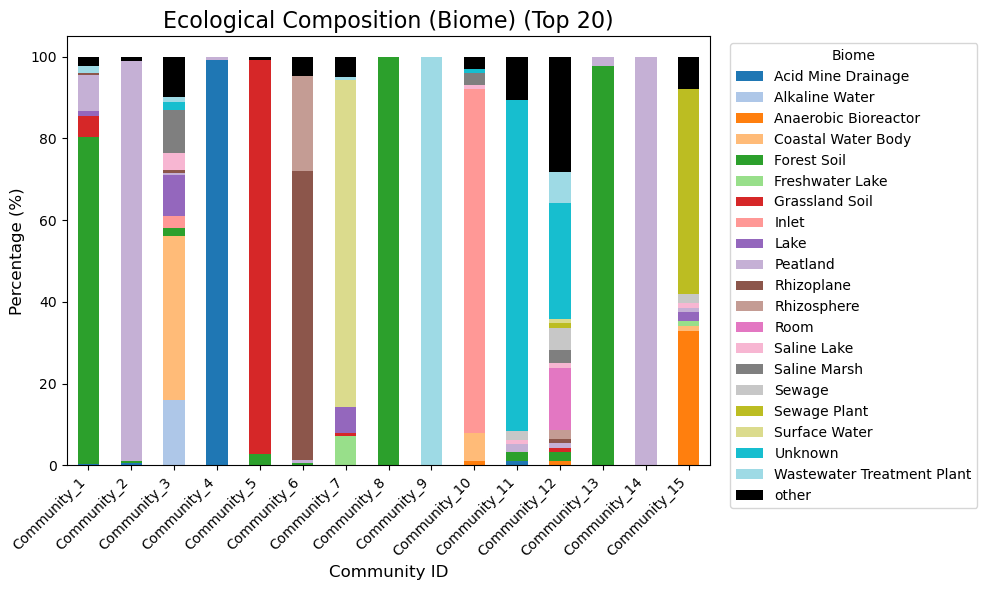

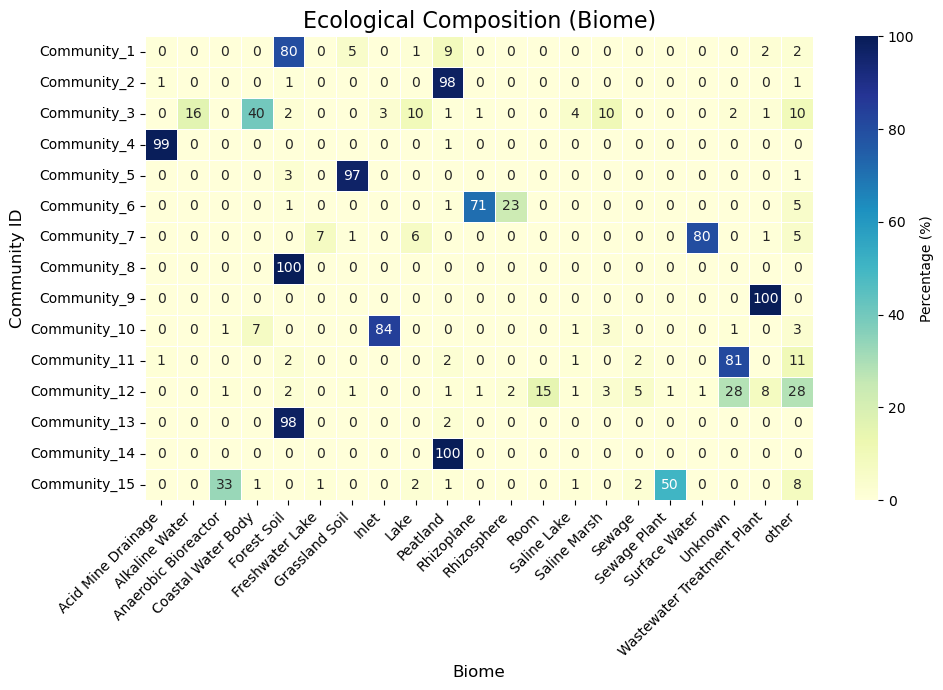

ANALYSIS: Community vs. product_categories
Note: Grouped -12 rare categories into 'Other'.


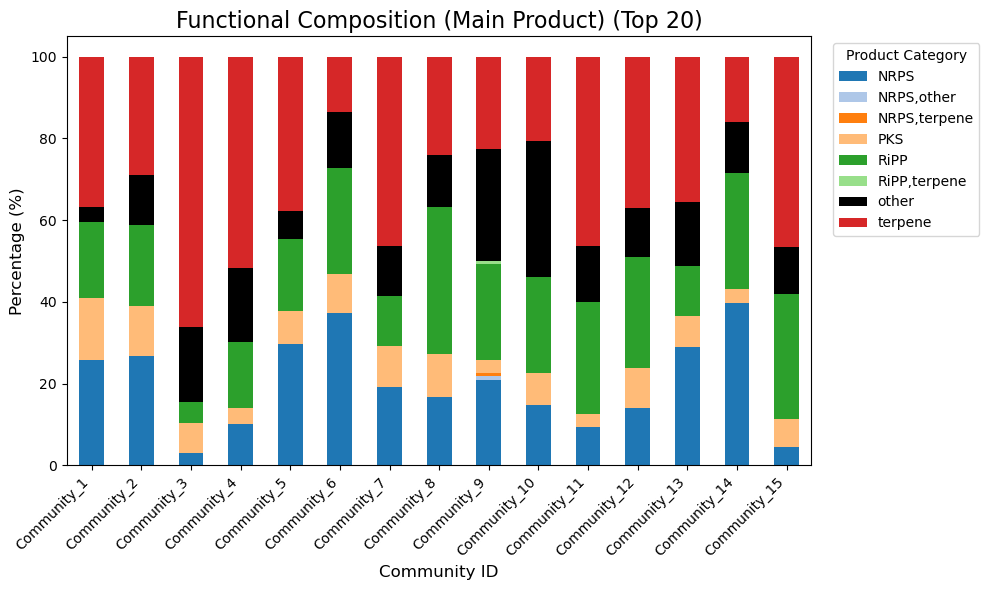

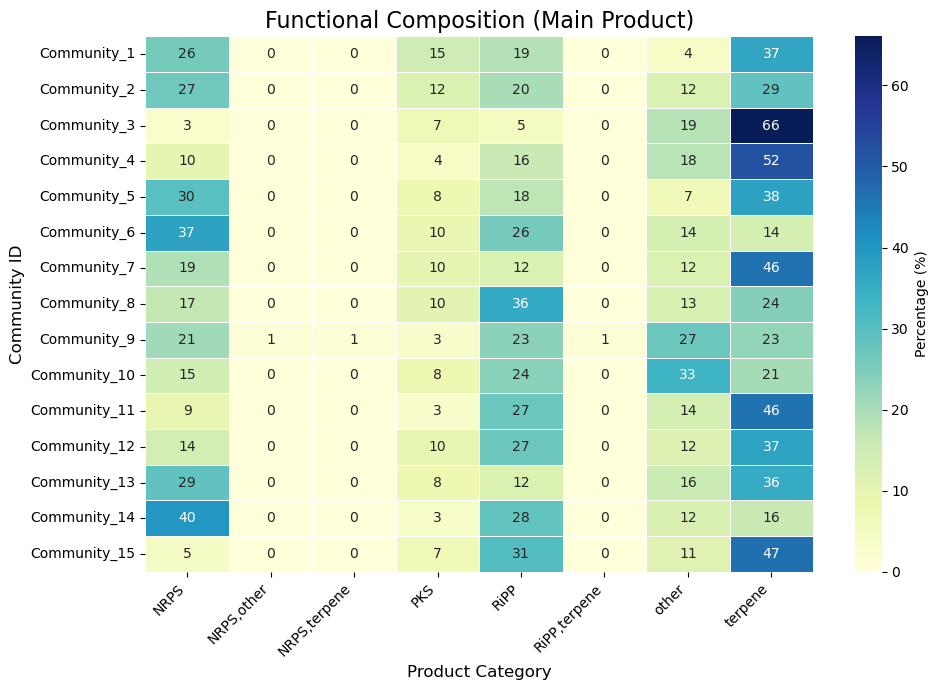

ANALYSIS: Community vs. product_subcategory
Note: Grouped 36 rare categories into 'Other'.


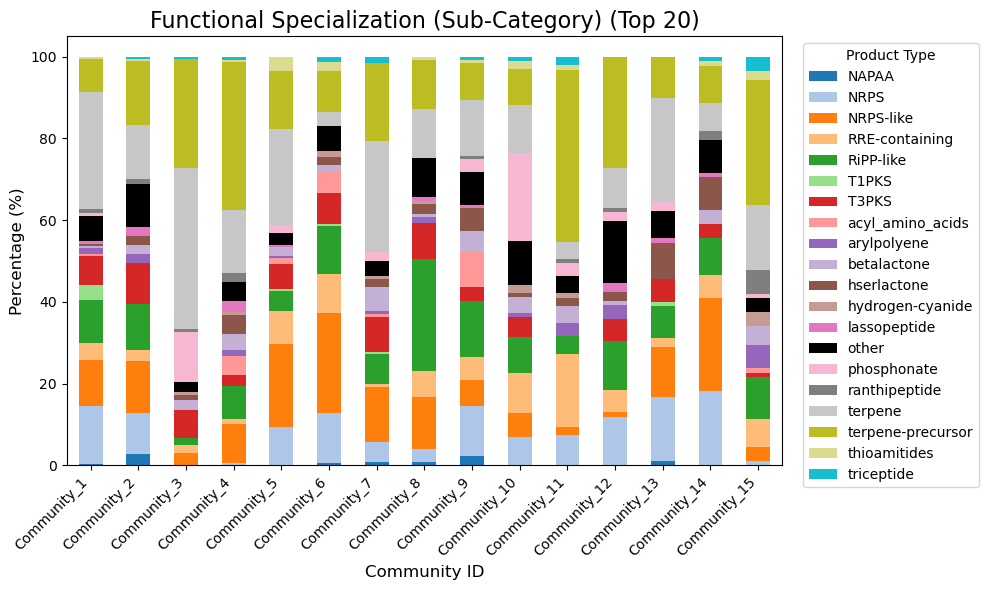

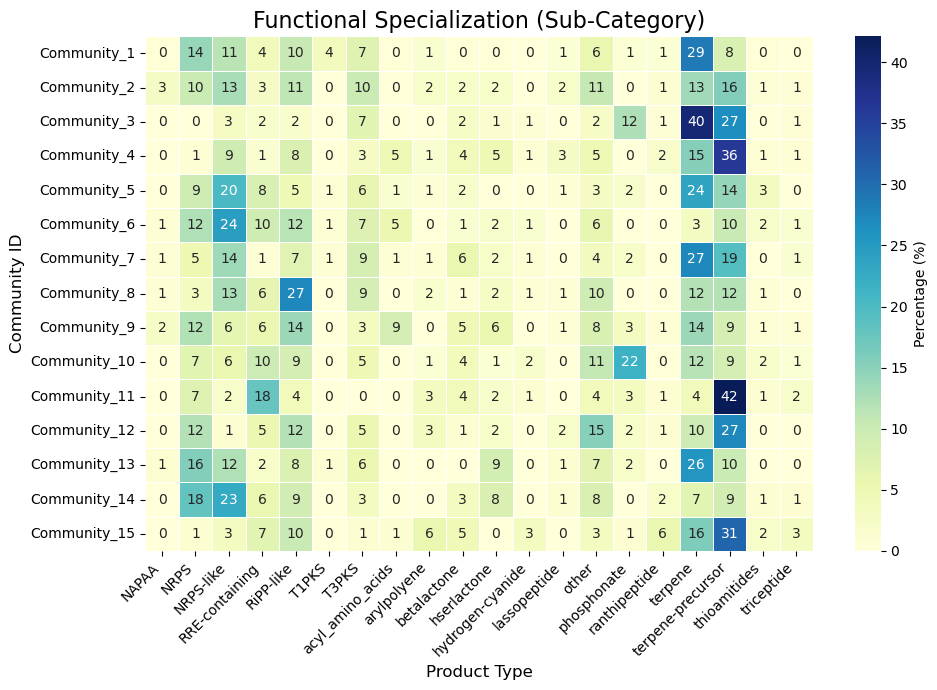

ANALYSIS: Community vs. genus_id
Note: Grouped 708 rare categories into 'Other'.


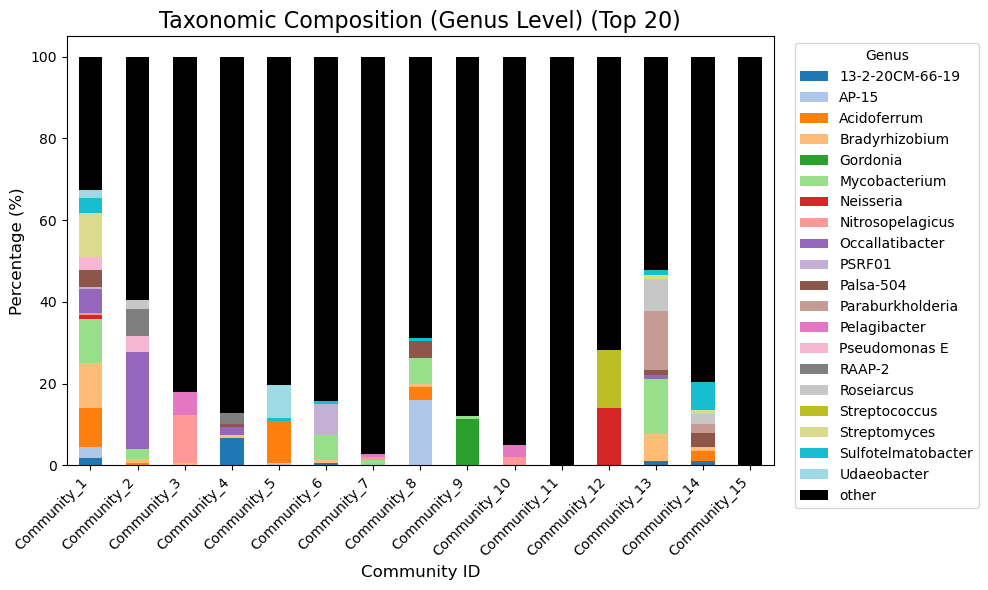

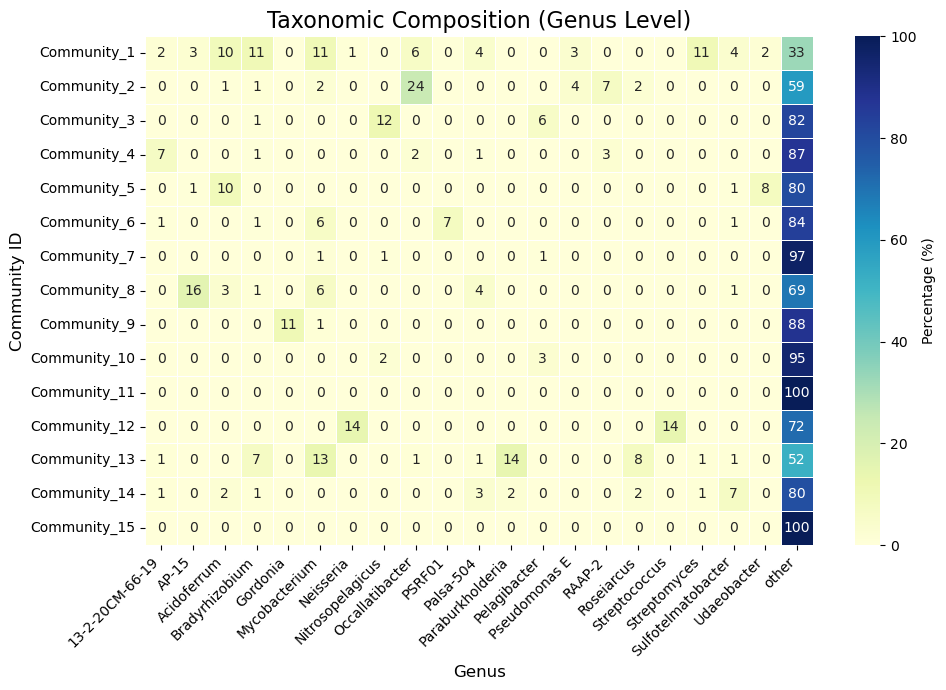

ANALYSIS: Community vs. family_id
Note: Grouped 335 rare categories into 'Other'.


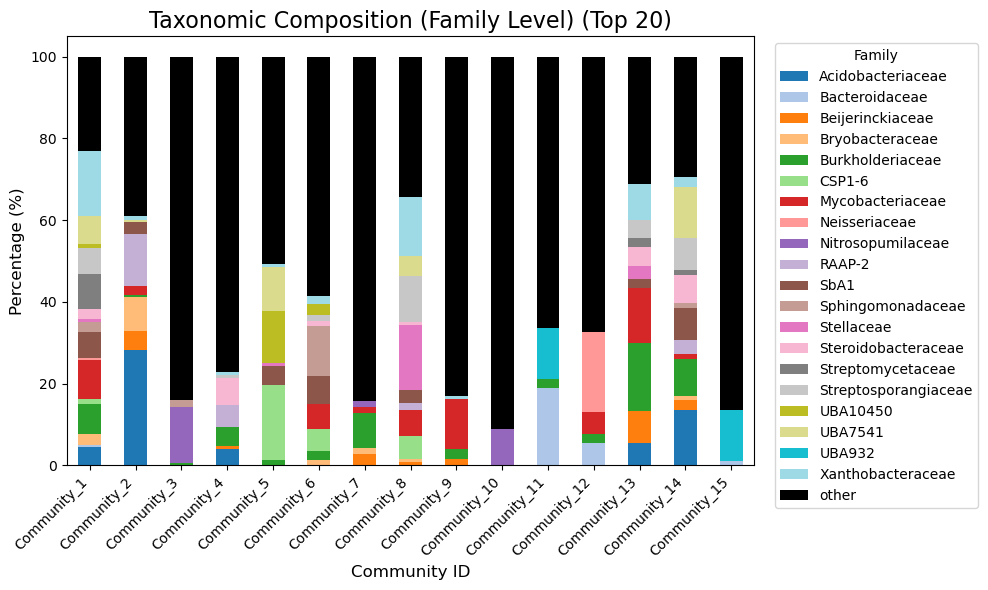

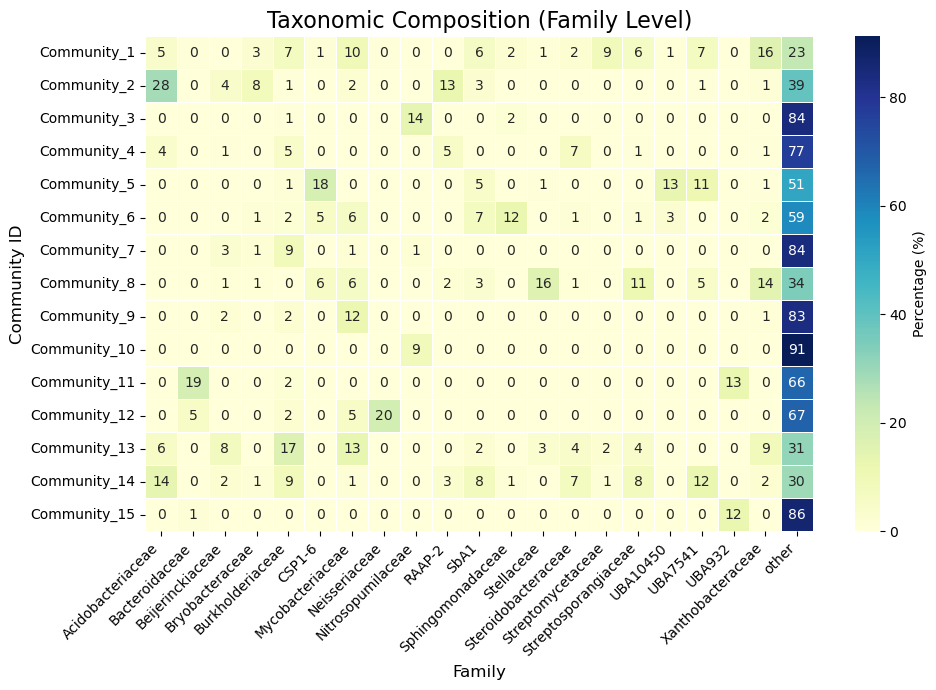

ANALYSIS: Community vs. species_id
Note: Grouped 1271 rare categories into 'Other'.


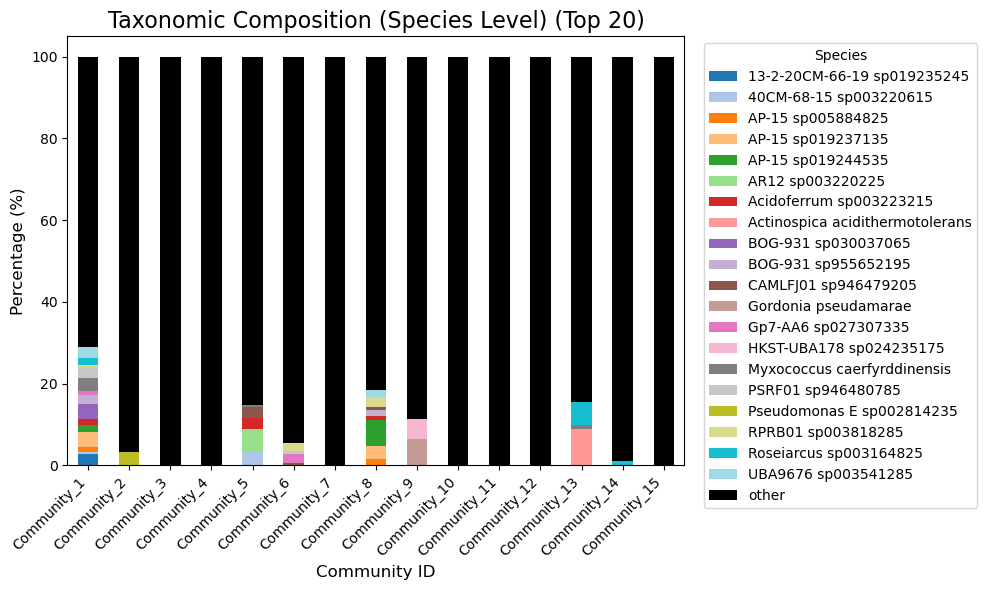

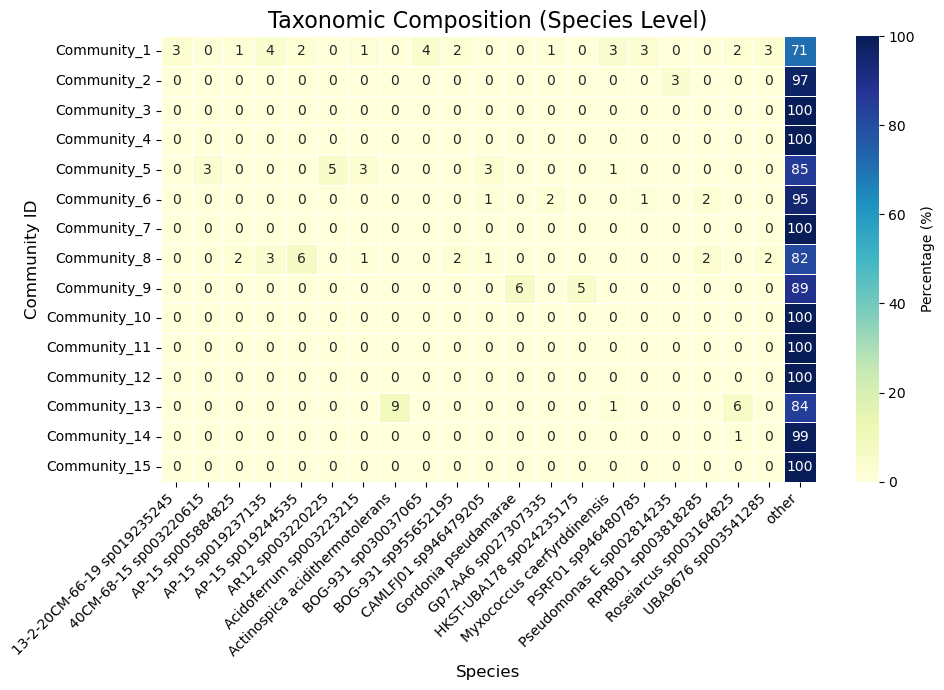

In [15]:
# Ecological Niche (Biome)
analyze_community_composition(
    G_jaccard, 
    attribute_name='dominant_biome', 
    plot_title='Ecological Composition (Biome)', 
    legend_title='Biome'
)

# Functional Potential
analyze_community_composition(
    G_jaccard, 
    attribute_name='product_categories', 
    plot_title='Functional Composition (Main Product)', 
    legend_title='Product Category',
)

# Functional Specialization (Sub-Category)
analyze_community_composition(
    G_jaccard, 
    attribute_name='product_subcategory', 
    plot_title='Functional Specialization (Sub-Category)', 
    legend_title='Product Type',
    top_n=20
)

# Taxonomy (Genus Level)
analyze_community_composition(
    G_jaccard, 
    attribute_name='genus_id', 
    plot_title='Taxonomic Composition (Genus Level)', 
    legend_title='Genus',
    top_n=20
)

# Taxonomy (Family Level)
analyze_community_composition(
    G_jaccard, 
    attribute_name='family_id', 
    plot_title='Taxonomic Composition (Family Level)', 
    legend_title='Family',
    top_n=20
)

# Taxanomy (Species Level)
analyze_community_composition(
    G_jaccard, 
    attribute_name='species_id', 
    plot_title='Taxonomic Composition (Species Level)', 
    legend_title='Species',
    top_n=20
)

# Visualization: Deep Dive

DEEP DIVE HEATMAP: dominant_biome
Showing 13 categories that are >20% abundant in at least one cluster.


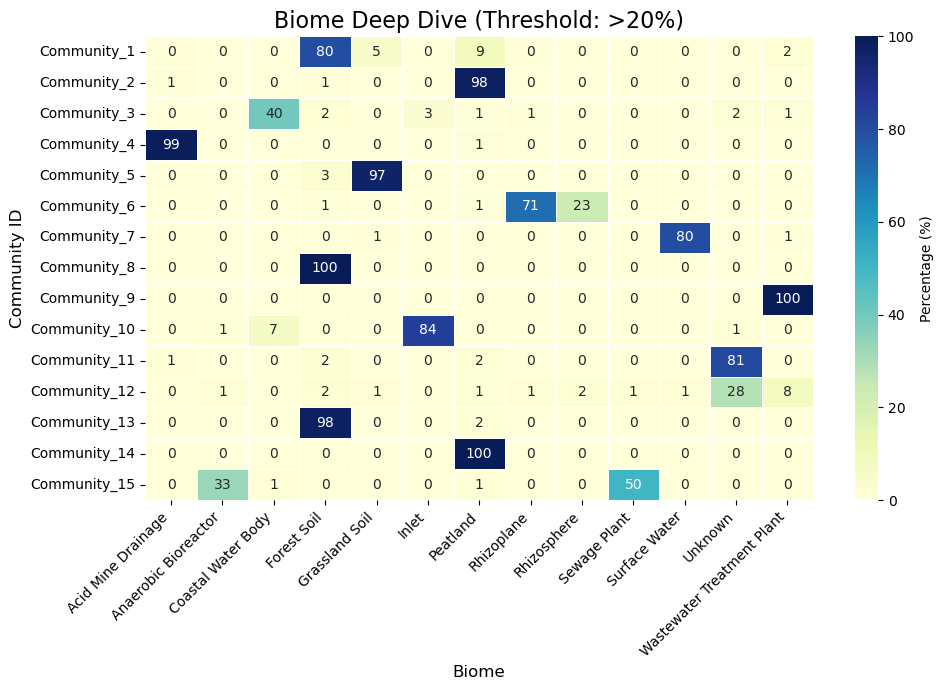

DEEP DIVE HEATMAP: product_categories
Showing 4 categories that are >10% abundant in at least one cluster.


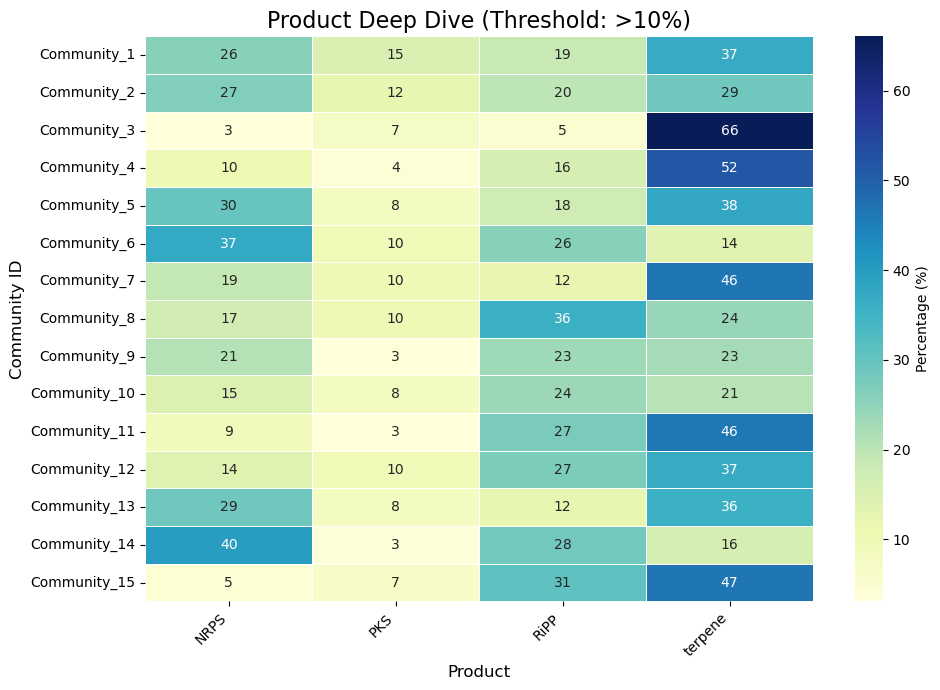

DEEP DIVE HEATMAP: product_subcategory
Showing 8 categories that are >10% abundant in at least one cluster.


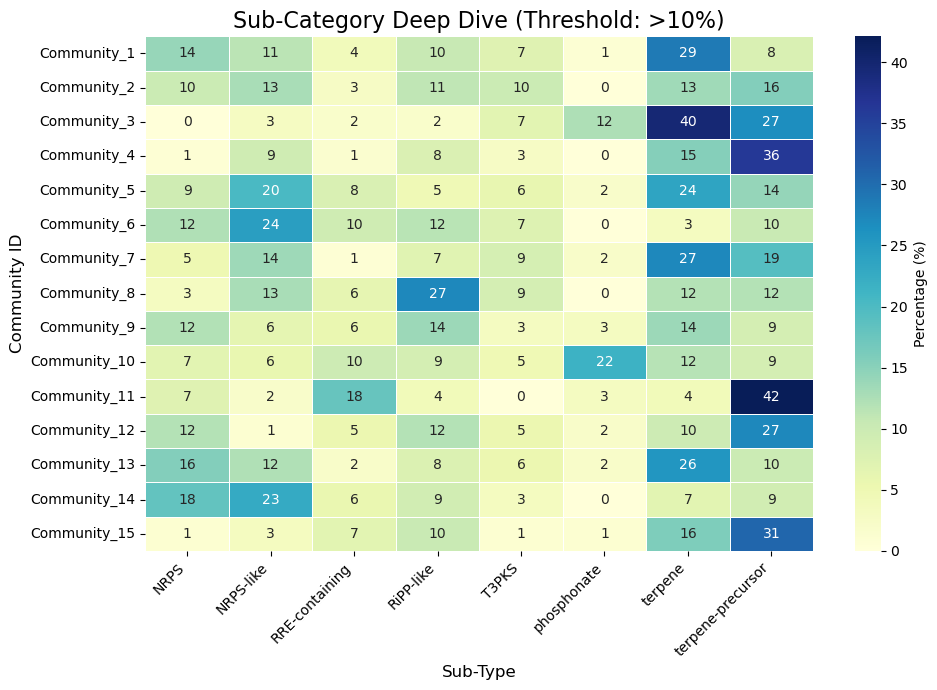

DEEP DIVE HEATMAP: genus_id
Showing 12 categories that are >10% abundant in at least one cluster.


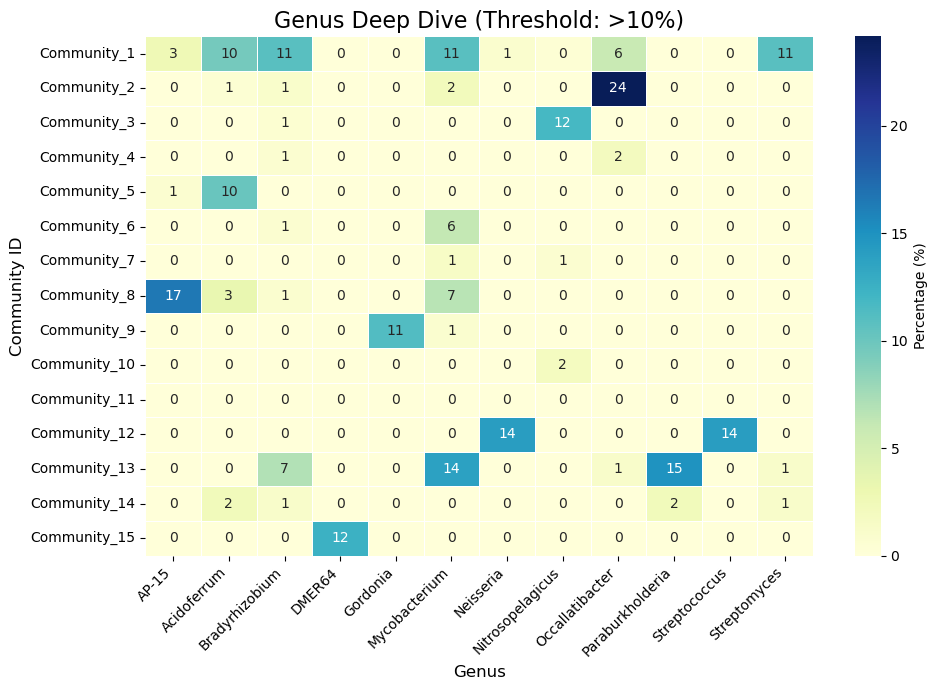

DEEP DIVE HEATMAP: family_id
Showing 21 categories that are >10% abundant in at least one cluster.


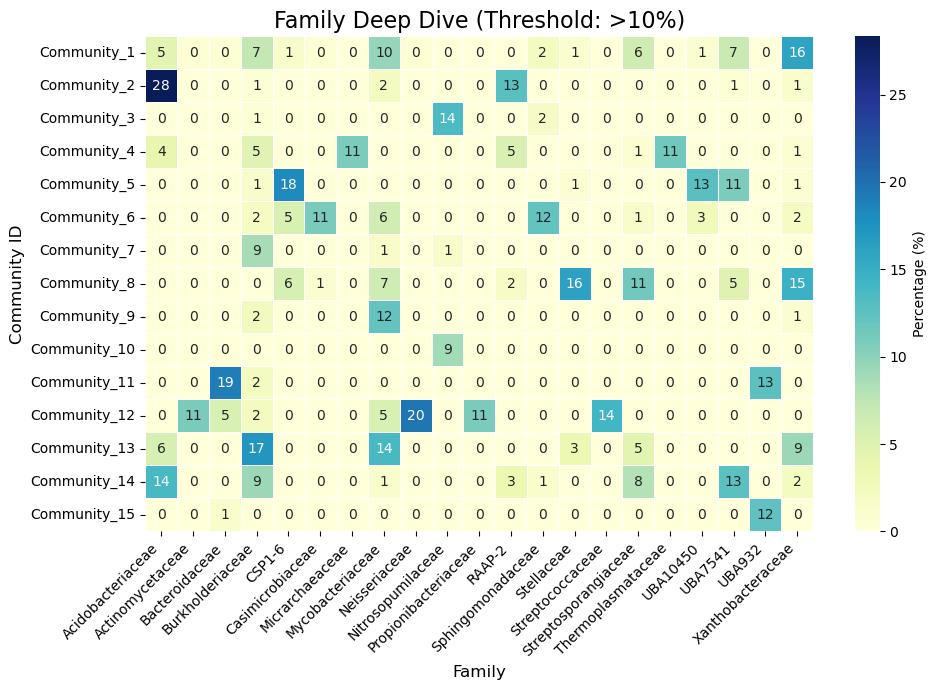

DEEP DIVE HEATMAP: species_id
Showing 7 categories that are >5% abundant in at least one cluster.


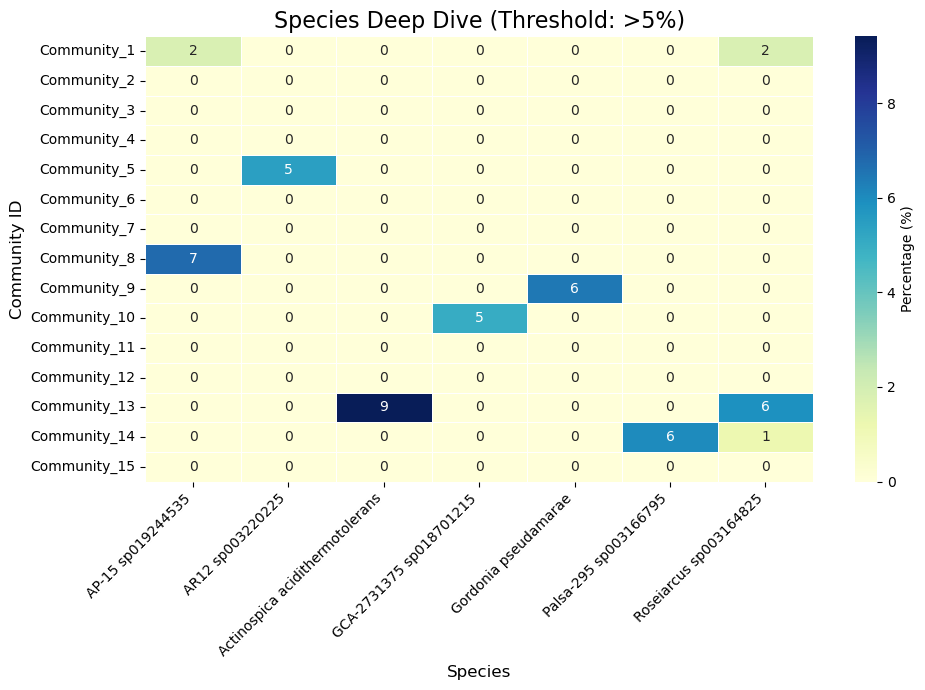

In [16]:
# RUN DEEP DIVE ANALYSES

# Biome
plot_deep_dive_heatmap(G_jaccard, 'dominant_biome', 'Biome Deep Dive', 'Biome', threshold_percent=20)

# Product
plot_deep_dive_heatmap(G_jaccard, 'product_categories', 'Product Deep Dive', 'Product', threshold_percent=10)

# Product Subcategories
plot_deep_dive_heatmap(G_jaccard, 'product_subcategory', 'Sub-Category Deep Dive', 'Sub-Type', threshold_percent=10)

# Taxonomy Genus
plot_deep_dive_heatmap(G_jaccard, 'genus_id', 'Genus Deep Dive', 'Genus', threshold_percent=10)

# Taxonomy Family
plot_deep_dive_heatmap(G_jaccard, 'family_id', 'Family Deep Dive', 'Family', threshold_percent=10)

# Taxonomy Species
plot_deep_dive_heatmap(G_jaccard, 'species_id', 'Species Deep Dive', 'Species', threshold_percent=5)

In [17]:
current_graph = G_jaccard
current_partition = partition   # The corresponding partition dictionary

disconnected_communities = []

# Iterate over all unique community IDs
for comm_id in set(current_partition.values()):
    # Get all nodes belonging to this community
    nodes = [n for n, c in current_partition.items() if c == comm_id]
    
    # Create a subgraph comprising only these nodes
    subgraph = current_graph.subgraph(nodes)
    
    # Check if this subgraph is fully connected
    if not nx.is_connected(subgraph):
        disconnected_communities.append(comm_id)

print(f"Number of disconnected communities: {len(disconnected_communities)}")

if len(disconnected_communities) > 0:
    print(f"Affected IDs: {disconnected_communities}")
else:
    print("All communities are perfectly connected!")

Number of disconnected communities: 0
All communities are perfectly connected!


In [18]:
# 1. Convert network partition (dictionary) to a DataFrame
# 'partition' is already in memory from the community detection step
df_communities = pd.DataFrame(list(partition.items()), columns=['gcf_id', 'community_id'])

# 2. Merge community info with the BGC data
# This links every GCF to its specific BGCs (filenames)
df_result = pd.merge(df_communities, df_merged, on='gcf_id', how='inner')

# 3. Rename columns to the desired format
df_result = df_result.rename(columns={
    'community_id': 'Community', 
    'gcf_id': 'GCF', 
    'filename': 'BGC'
})

# 4. SMART SORTING (Crucial Step)
# We sort by Community and GCF, but also by 'is_complete' if available.
# Ascending=[True, True, False] means:
# - Community 0->9
# - GCF A->Z
# - is_complete: TRUE (top) -> FALSE (bottom).
# This ensures the BEST BGC is always the first one listed for its group.
if 'is_complete' in df_result.columns:
    df_result = df_result.sort_values(by=['Community', 'GCF', 'is_complete'], 
                                      ascending=[True, True, False])
else:
    # Fallback if 'is_complete' is missing
    df_result = df_result.sort_values(by=['Community', 'GCF'])

# 5. STRICTLY select only the requested columns
# Now we remove the helper columns (like is_complete), keeping only the 3 you wanted.
df_result = df_result[['Community', 'GCF', 'BGC']]

# 6. Drop Duplicates
# Since we sorted above, we keep the highest quality entry if duplicates exist.
df_result = df_result.drop_duplicates()
print(f"Rows after cleanup: {len(df_result)}")

# 7. Save the clean table to a CSV file
output_path = "../data/Jaccard_Community_GCF_BGC_Table.csv"
df_result.to_csv(output_path, index=False)

Rows after cleanup: 6482547


In [29]:
print(df_merged.columns)

Index(['filename', 'assembly_accession', 'analysis_accession',
       'antismash_run_file_path', 'contig', 'start_pos', 'end_pos',
       'product_category', 'product_type', 'anchor', 'is_complete',
       'num_cds_features', 'pipeline_version', 'gcf_id',
       'gcf_membership_score', 'gcf_score_origin', 'mmseqs_taxonomy',
       'dominant_biome', 'tax_family', 'tax_genus', 'tax_species'],
      dtype='object')
